In [34]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
import pandas as pd

In [35]:
df = pd.read_csv('wine-reviews.csv', usecols = ['country' ,'description',  'points' , 'price' , 'variety' , 'winery'])

In [36]:
df.head()

,country,description,points,price,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,NaN,White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Pinot Noir,Sweet Cheeks


In [37]:
df = df.dropna(subset=[ 'description', 'points'])

In [38]:
df.head()

,country,description,points,price,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,NaN,White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Pinot Noir,Sweet Cheeks


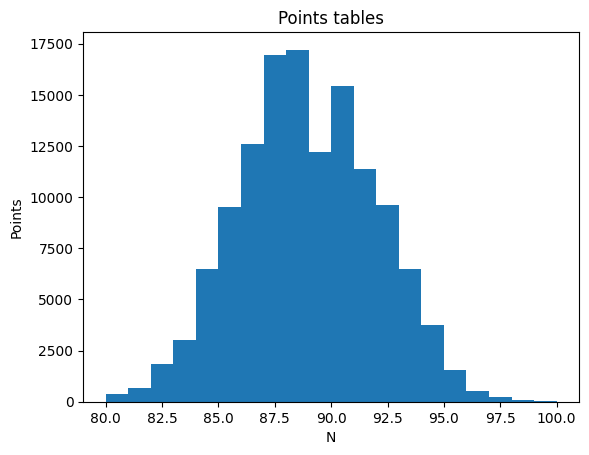

In [10]:
plt.hist(df.points , bins= 20)  # this line creates a histogram using the 'points' column data from the DataFrame 'df'.
plt.xlabel('N')
plt.ylabel('Points')
plt.show()

In [39]:
df['labels'] = (df.points>= 90).astype(int)

df = df[['labels','description']]
# the entire line of code assigns labels of 1 to rows where 'points' is 90 or greater and labels of 0 to rows where
#'points' is less than 90, and stores these labels in the new 'labels' column in the DataFrame 'df'

In [40]:
train, val, test = np.split(df.sample(frac=1), [int(0.8*len(df)), int(0.9*len(df))])

In [28]:
# len(train), len(val) , len(test)

In [43]:
def df_to_dataset(dataframe, shuffle=True, batch_size=1024):
  df = dataframe.copy()
  labels = df.pop('labels')
  df = df["description"]
  ds = tf.data.Dataset.from_tensor_slices((df, labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(tf.data.AUTOTUNE)
  return ds

In [44]:
train_data = df_to_dataset(train)
valid_data = df_to_dataset(val)
test_data = df_to_dataset(test)

In [ ]:
# embedding  and text

In [49]:
embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(embedding, dtype=tf.string, trainable=True)

In [50]:
hub_layer(list(train_data)[0][0])

<tf.Tensor: shape=(1024, 50), dtype=float32, numpy=
array([[ 0.2158085 , -0.20882179,  0.03093543, ...,  0.03688052,
        -0.12283042,  0.07104689],
       [ 0.46197116, -0.37072715, -0.30696404, ..., -0.06458164,
         0.15820257, -0.08962499],
       [ 0.25553003,  0.03531208, -0.10341953, ..., -0.01404705,
        -0.2774044 ,  0.0584347 ],
       ...,
       [ 0.52883816, -0.51240426,  0.15894327, ..., -0.00308921,
        -0.25243294, -0.21438581],
       [ 0.23696254, -0.33139282, -0.02484737, ..., -0.09076572,
         0.04268916, -0.10190763],
       [ 0.35758638, -0.17284714,  0.06075346, ..., -0.06633078,
        -0.13249324,  0.04029684]], dtype=float32)>

In [51]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [52]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [53]:
model.evaluate(train_data)

102/102 [==============================] - 4s 21ms/step - loss: 0.6729 - accuracy: 0.6226


[0.6728954315185547, 0.6226437091827393]

In [54]:
model.evaluate(valid_data)

13/13 [==============================] - 0s 14ms/step - loss: 0.6682 - accuracy: 0.6300


[0.6681795716285706, 0.6299915313720703]

In [57]:
history = model.fit(train_data, epochs=5, validation_data=valid_data)

Epoch 1/5
102/102 [==============================] - 145s 1s/step - loss: 0.4859 - accuracy: 0.7744 - val_loss: 0.4348 - val_accuracy: 0.8127
Epoch 2/5
102/102 [==============================] - 149s 1s/step - loss: 0.4212 - accuracy: 0.8249 - val_loss: 0.4097 - val_accuracy: 0.8227
Epoch 3/5
102/102 [==============================] - 145s 1s/step - loss: 0.3871 - accuracy: 0.8420 - val_loss: 0.4017 - val_accuracy: 0.8223
Epoch 4/5
102/102 [==============================] - 149s 1s/step - loss: 0.3619 - accuracy: 0.8537 - val_loss: 0.4021 - val_accuracy: 0.8243
Epoch 5/5
102/102 [==============================] - 148s 1s/step - loss: 0.3430 - accuracy: 0.8648 - val_loss: 0.4036 - val_accuracy: 0.8239


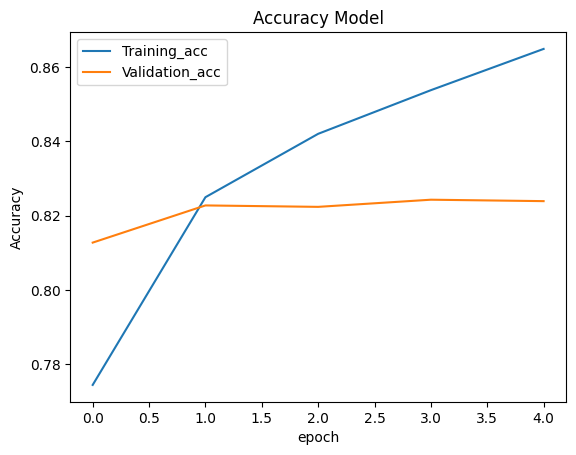

In [60]:
plt.plot(history.history['accuracy'], label = 'Training_acc')
plt.plot(history.history['val_accuracy'], label = 'Validation_acc')
plt.title('Accuracy Model')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()

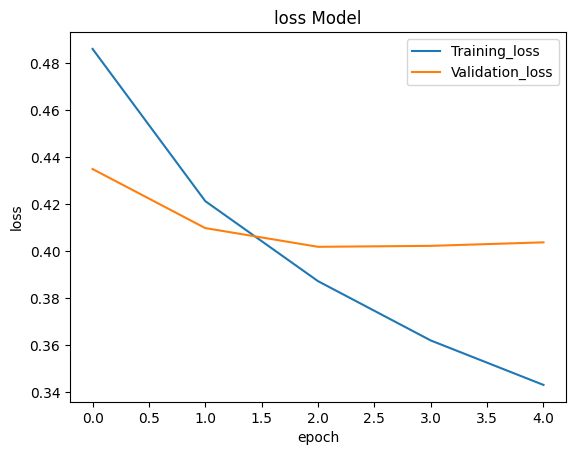

In [62]:
plt.plot(history.history['loss'], label = 'Training_loss')
plt.plot(history.history['val_loss'], label = 'Validation_loss')
plt.title('loss Model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

In [ ]:
# lstm

In [63]:
encoder = tf.keras.layers.TextVectorization(max_tokens=2000)
encoder.adapt(train_data.map(lambda text, label: text))

In [64]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'and', 'the', 'a', 'of', 'with', 'this', 'is', 'wine',
       'flavors', 'in', 'it', 'to', 'its', 'on', 'fruit', 'aromas',
       'palate', 'that'], dtype='<U17')

In [65]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=32,
        mask_zero=True
    ),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [66]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [67]:
model.evaluate(train_data)
model.evaluate(valid_data)

13/13 [==============================] - 2s 174ms/step - loss: 0.6935 - accuracy: 0.4596


[0.6934887766838074, 0.45964452624320984]

In [68]:
history = model.fit(train_data, epochs=5, validation_data=valid_data)

Epoch 1/5
102/102 [==============================] - 57s 505ms/step - loss: 0.5437 - accuracy: 0.7129 - val_loss: 0.3806 - val_accuracy: 0.8313
Epoch 2/5
102/102 [==============================] - 50s 490ms/step - loss: 0.3654 - accuracy: 0.8360 - val_loss: 0.3575 - val_accuracy: 0.8399
Epoch 3/5
102/102 [==============================] - 49s 480ms/step - loss: 0.3487 - accuracy: 0.8435 - val_loss: 0.3509 - val_accuracy: 0.8417
Epoch 4/5
102/102 [==============================] - 51s 498ms/step - loss: 0.3417 - accuracy: 0.8472 - val_loss: 0.3477 - val_accuracy: 0.8408
Epoch 5/5
102/102 [==============================] - 50s 494ms/step - loss: 0.3366 - accuracy: 0.8490 - val_loss: 0.3509 - val_accuracy: 0.8393


In [69]:
model.evaluate(test_data)

13/13 [==============================] - 2s 170ms/step - loss: 0.3460 - accuracy: 0.8398


[0.34595200419425964, 0.8398215174674988]